In [1]:
# Beginning of "prototyping_notebook.ipynb"

# Prototyping Notebook

This notebook is for prototyping functions and other logic that will be used in the Personal Finance Project. This project will create a data pipeline that will take a CSV file, clean the data, ensure proper data types then load in a PostgreSQL database. A simple DAG will take the financial data from the database and process the data into four datasets. Another script will intake the aforementioned datasets and create a Shiny web app detailing some important metrics from the financial data.

## Section 0: Setup Environment

Import necessary libraries, initiate current directory and import the CSV file.

In [40]:
# Import all necessary libraries and module
from pathlib import Path
import os
import pandas as pd
import re # Regular expression library also for removing apostrophes
import psycopg2 # To handle connection to postgresql
import yaml # For configuration file
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1234)
import random
import time
from datetime import datetime, timedelta
# Some custom helper functions
from helper_funcs.pfp_helper_funcs import rm_plot2_cols, process_plot4

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# Get the current directory
current_directory=Path.cwd()
# Sanity check: confirm that we are in the correct directory.
print(current_directory)

/run/media/joebravo/Extreme SSD/personal_finances_project


In [4]:
# Navigate to directory containing needed file
file_path = Path('data/DEC_2023.csv')

# Store pandas dataframe (df) into variable
raw_data = pd.read_csv(file_path)
# Ensure date column is appropriate data type
raw_data['date'] = pd.to_datetime(raw_data['date']).dt.date

raw_data.tail() # Check final 5 records

,date,day,description,category,amount
105,2023-12-30,Saturday,Mira Mesa Crown Liquor,drinks,17.99
106,2023-12-30,Saturday,Chevron,groceries,2.79
107,2023-12-30,Saturday,Hyatt House,parking,16.00
108,2023-12-31,sunday,Quick Mart,drinks,12.58
109,2023-12-31,sunday,76 Fuel,groceries,3.32


In [5]:
# Sanity check: get data types of the different fields
raw_data.dtypes

date            object
day             object
description     object
category        object
amount         float64
dtype: object

Use conditonal statements to check the data types of each column and then change if it's not the necessary data type for analysis.

In [6]:
if raw_data.date.dtype != object:
    print("it's not an object dtype")
else:
    print("it's an object data type")

it's an object data type


Create and test a function that removes apostrophes from strings in a Pandas column. This function was not necessary once I found alternative ways to get the CSV file into the Postgres database.

In [7]:
def remove_apostrophe(df, col):
    df[col] = df[col].astype(str).apply(lambda x: re.sub(r"'", "", x))
    return df

# Create testing data
data = {'text': ["this's a string", "Otter's Den", "TGIFridays", "Applebee's"]}
df = pd.DataFrame(data)
df = remove_apostrophe(df, 'text')

# Test the function
print(df)

             text
0  thiss a string
1      Otters Den
2      TGIFridays
3       Applebees


## Section 1: Helper Functions

Some logic to convert the day column to lowercase and a check.

In [8]:
# Convert 'col1' to lowercase
raw_data['day'] = raw_data['day'].str.lower()
# Confirm previous operation
raw_data.head()

,date,day,description,category,amount
0,2023-12-01,friday,Tlatoani Barbershop,haircut,60.00
1,2023-12-01,friday,Andy's Boy,meds,60.00
2,2023-12-01,friday,Nob Hill Foods,drinks,13.43
3,2023-12-01,friday,TicketWeb,entertainment,49.20
4,2023-12-02,saturday,Lyft,rideshare,6.00


In [9]:
# Should get monday to sunday in lowercase
raw_data['day'].unique()

array(['friday', 'saturday', 'sunday', 'monday', 'tuesday', 'wednesday',
       'thursday'], dtype=object)

Want to buddle the logic above into a function to use in the DAG for this project.

In [10]:
def process_day_col(df):
    """Helper function to make all strings in day column lower case."""
    df['day'] = df['day'].str.lower()
    return df

Test the `process_day_col` function.

In [11]:
# Create a copy of the original df
input_df = raw_data

# Apply function to df copy and store in variable
processed_df = process_day_col(input_df)

# Should match output of raw_data.head()
processed_df.head()

,date,day,description,category,amount
0,2023-12-01,friday,Tlatoani Barbershop,haircut,60.00
1,2023-12-01,friday,Andy's Boy,meds,60.00
2,2023-12-01,friday,Nob Hill Foods,drinks,13.43
3,2023-12-01,friday,TicketWeb,entertainment,49.20
4,2023-12-02,saturday,Lyft,rideshare,6.00


Confirm the expected columns in the newly processed df.

In [12]:
processed_df.columns

Index(['date', 'day', 'description', 'category', 'amount'], dtype='object')

Function that reads a CSV file using Pandas, then creates SQL insert queries to insert data into a PostgreSQL table. *Nota Bene*: each transaction/row in the finances CSV file becomes its own query that will be inserted as a record in the new table.

In [13]:
def generate_insert_queries(filepath):
    # Read the CSV file
    df = pd.read_csv(filepath)
    # Creae a list of SQL insert queries
    insert_queries = []
    for idx, row in df.iterrows():
        insert_query = f"INSERT INTO sample_table (date, 'day', 'description', 'category', amount) VALUES ({row['date']}, {row['day']}, {row['description']}, {row['category']}, {row['amount']});"
        insert_queries.append(insert_query)
    # Save queries to a file for the SQL Operator to execute
    with open('./data/insert_queries.sql', 'w') as f:
        for query in insert_queries:
            f.write(f"{query}\n")


In [14]:
generate_insert_queries(file_path)

## Section 2: Accessing Database

Will open a connection to the correct table in PostgreSQL and (just as importantly) close the connection. While open, will obtain some Pandas dataframes.

In [15]:
# Read the config file
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

# Create a connection to db server
conn = psycopg2.connect(
    f"host={config["server"]["host"]} \
    dbname={config["database"]["name"]} \
    user={config["database"]["user"]} \
    password={config["database"]["password"]} \
    "
)

# Define query
query = "SELECT * FROM dec_2023;"

# Time series query
query_2 = "SELECT date, SUM(amount) \
    FROM dec_2023 \
    GROUP BY date \
    ORDER BY date ASC;"

# Import query results into df's
plot_1 = pd.read_sql_query(query, conn)
plot_2 = rm_plot2_cols(plot_1)
plot_3 = pd.read_sql_query(query_2, conn)
plot_4 = process_plot4(plot_1)
# Want one copy of the Plot 1 data for experimentation
df = plot_1

# Close the connection
conn.close()

/tmp/ipykernel_4373/2353456509.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  plot_1 = pd.read_sql_query(query, conn)
/tmp/ipykernel_4373/2353456509.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  plot_3 = pd.read_sql_query(query_2, conn)


An experimental function that creates a new column that is the proportion spent per description.

In [16]:
def process_plot4(df):
    """All the processing for plot 4."""
    # Total spent
    total_spent = df['amount'].sum().round(2)
    # Remove unnecessary columns
    df = df.drop(columns=['txn_id', 'date', 'day', 'category'])
    # Group By
    df = df.groupby('description', as_index=False).sum()
    # Compute new column
    df['proportion'] = df.apply(lambda row: row['amount'] / total_spent, axis=1)
    df = df.sort_values(by='proportion', ascending=True)
    df = df.tail(20)
    return df

x = process_plot4(plot_1)
print(x)

                     description  amount  proportion
30     Lazy Dog Restaurant & Bar   64.00    0.015100
36                        Mezcal   73.74    0.017398
61             Total Wine & More   75.06    0.017709
31       Lighthouse Publications   75.40    0.017790
19  Dubber's Oldtown Bar & Grill   79.74    0.018814
4                BJ's Restaurant   87.69    0.020689
3                     Applebee's   92.21    0.021756
42                Nob Hill Foods   95.16    0.022452
12      California Pizza Kitchen  102.82    0.024259
32                          Lyft  103.53    0.024427
57        The Cheesecake Factory  108.16    0.025519
66                          Vans  120.19    0.028357
8               Beverages & More  120.29    0.028381
28                         Kohls  120.79    0.028499
10            Buffalo Wild Wings  176.98    0.041756
60           Tlatoani Barbershop  180.00    0.042469
45               Pandora Jewelry  224.48    0.052963
22                  Hilton Hotel  259.66    0.

A quick view of the newly processed data (from a couple cells ago) that will be used for plotting.

In [17]:
# Plot 1 Data
plot_1.head(10)

,txn_id,date,day,description,category,amount
0,0,2023-12-01,friday,Tlatoani Barbershop,haircut,60.00
1,1,2023-12-01,friday,Nob Hill Foods,drinks,13.43
2,2,2023-12-01,friday,TicketWeb,entertainment,49.20
3,3,2023-12-02,saturday,Lyft,rideshare,6.00
4,4,2023-12-02,saturday,street vendor,eating out,5.00
5,5,2023-12-02,saturday,Hilton Hotel,hotels,259.66
6,6,2023-12-02,saturday,Mezcal,restaurant,73.74
7,7,2023-12-02,saturday,The Cheesecake Factory,restaurant,108.16
8,8,2023-12-02,saturday,Beverages & More,miscellaneous,26.88
9,9,2023-12-02,saturday,Lyft,rideshare,15.85


More processing of Plot 1 that uses a GROUP BY operation to get total spent per category.

In [18]:
plot_1 = plot_1.drop(columns=['txn_id', 'date', 'day', 'description'])
plot_1 = plot_1.groupby('category', as_index=False).sum()
plot_1 = plot_1.sort_values(by='amount', ascending=False)
plot_1.head(10)

,category,amount
18,restaurant,851.74
10,gifts,646.35
20,student loans,528.30
2,child support,450.00
3,drinks,345.08
14,hotels,259.66
4,eating out,200.74
13,haircut,180.00
15,miscellaneous,158.14
11,groceries,126.05


A simple pandas-based bar plot of Plot 1.

<Axes: xlabel='category'>

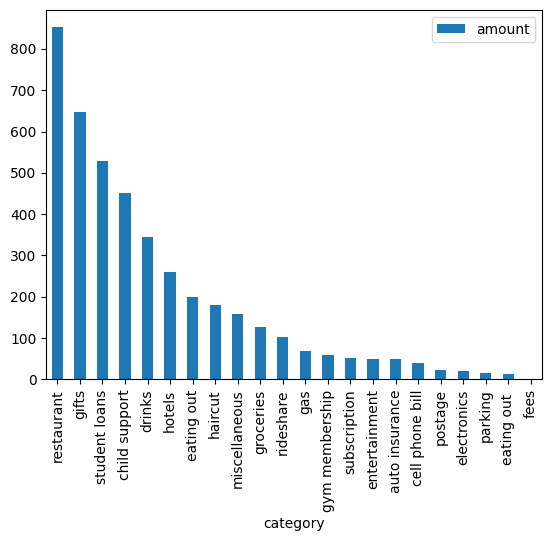

In [19]:
plot_1.plot('category', 'amount', kind='bar')

In [20]:
# Plot 2 Data
plot_2.head(10)

,category,amount
0,haircut,60.00
1,drinks,13.43
2,entertainment,49.20
3,rideshare,6.00
4,eating out,5.00
5,hotels,259.66
6,restaurant,73.74
7,restaurant,108.16
8,miscellaneous,26.88
9,rideshare,15.85


In [21]:
# Plot 3 Data
plot_3.head()

,date,sum
0,2023-12-01,122.63
1,2023-12-02,534.11
2,2023-12-03,74.03
3,2023-12-04,93.61
4,2023-12-05,5.13


Save the Plot 3 as Plot 4 CSV. This is time-based data.

In [22]:
plot_3.to_csv('data/plot4_data.csv', index=False)

## Section 3: Plotting Processed Data

Following is some scratchwork with the data and plots that will be used in the Shiny App.

Recall copy created earlier of Plot 1 data to experiment with some data manipulation.

In [23]:
# Verify contents of "df"
print(df.head(10))

   txn_id        date       day             description       category  amount
0       0  2023-12-01    friday     Tlatoani Barbershop        haircut   60.00
1       1  2023-12-01    friday          Nob Hill Foods         drinks   13.43
2       2  2023-12-01    friday               TicketWeb  entertainment   49.20
3       3  2023-12-02  saturday                    Lyft      rideshare    6.00
4       4  2023-12-02  saturday           street vendor     eating out    5.00
5       5  2023-12-02  saturday            Hilton Hotel         hotels  259.66
6       6  2023-12-02  saturday                  Mezcal     restaurant   73.74
7       7  2023-12-02  saturday  The Cheesecake Factory     restaurant  108.16
8       8  2023-12-02  saturday        Beverages & More  miscellaneous   26.88
9       9  2023-12-02  saturday                    Lyft      rideshare   15.85


In [24]:
print(df['amount'].dtype)

float64


Logic above confirms that the amount (in US dollars) column is a float64 data type. So, don't need to use the logic belove to cast as a float 64 type, but available if nedeed.

In [25]:
# df['amount'] = df['amount'].astype(float)

Example use of the box plot from the amount column in the "df" dataframe.

<Axes: >

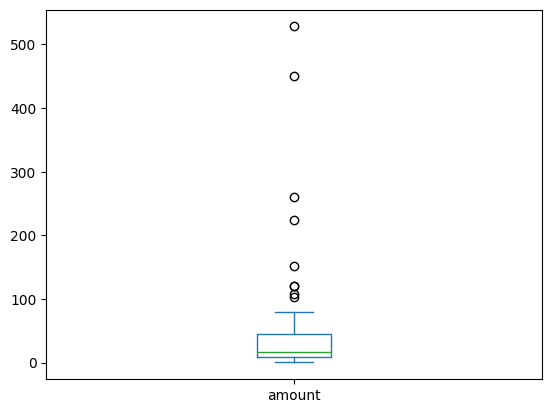

In [26]:
df.plot(
    kind = 'box',
    x = 'category',
    y = 'amount'
)

Want to add an index column to the dataframe. The postgres table has index column "txn_id" that is unique to each transaction and is the primary serial key for each table.

In [27]:
processed_df.head(10)

,date,day,description,category,amount
0,2023-12-01,friday,Tlatoani Barbershop,haircut,60.00
1,2023-12-01,friday,Andy's Boy,meds,60.00
2,2023-12-01,friday,Nob Hill Foods,drinks,13.43
3,2023-12-01,friday,TicketWeb,entertainment,49.20
4,2023-12-02,saturday,Lyft,rideshare,6.00
5,2023-12-02,saturday,street vendor,eating out,5.00
6,2023-12-02,saturday,Hilton Hotel,hotels,259.66
7,2023-12-02,saturday,Mezcal,restaurant,73.74
8,2023-12-02,saturday,The Cheesecake Factory,restaurant,108.16
9,2023-12-02,saturday,Beverages & More,miscellaneous,26.88


In [28]:
processed_df.insert(0, 'txn_id', range(len(processed_df)))
processed_df.tail(10)

,txn_id,date,day,description,category,amount
100,100,2023-12-30,saturday,Lazy Dog Restaurant & Bar,restaurant,64.00
101,101,2023-12-30,saturday,Best Buy,electronics,19.69
102,102,2023-12-30,saturday,Lyft,rideshare,18.99
103,103,2023-12-30,saturday,Circle K,groceries,3.64
104,104,2023-12-30,saturday,Applebee's,restaurant,45.21
105,105,2023-12-30,saturday,Mira Mesa Crown Liquor,drinks,17.99
106,106,2023-12-30,saturday,Chevron,groceries,2.79
107,107,2023-12-30,saturday,Hyatt House,parking,16.00
108,108,2023-12-31,sunday,Quick Mart,drinks,12.58
109,109,2023-12-31,sunday,76 Fuel,groceries,3.32


Following is logic to create plots for the Shiny app. Will make another copy of the "df" dataframe.

In [29]:
df_2 = df
df_2.head(10)

,txn_id,date,day,description,category,amount
0,0,2023-12-01,friday,Tlatoani Barbershop,haircut,60.00
1,1,2023-12-01,friday,Nob Hill Foods,drinks,13.43
2,2,2023-12-01,friday,TicketWeb,entertainment,49.20
3,3,2023-12-02,saturday,Lyft,rideshare,6.00
4,4,2023-12-02,saturday,street vendor,eating out,5.00
5,5,2023-12-02,saturday,Hilton Hotel,hotels,259.66
6,6,2023-12-02,saturday,Mezcal,restaurant,73.74
7,7,2023-12-02,saturday,The Cheesecake Factory,restaurant,108.16
8,8,2023-12-02,saturday,Beverages & More,miscellaneous,26.88
9,9,2023-12-02,saturday,Lyft,rideshare,15.85


In [30]:
# Drop first 4 columns (Method 1) Using the 'drop' method
df_2 = df_2.drop(columns=['txn_id', 'date', 'day', 'description'])
df_2.tail(10)

,category,amount
95,restaurant,64.00
96,electronics,19.69
97,rideshare,18.99
98,groceries,3.64
99,restaurant,45.21
100,drinks,17.99
101,groceries,2.79
102,parking,16.00
103,drinks,12.58
104,groceries,3.32


Using a box plot for actual amount spent from my data.

<Axes: title={'center': 'amount'}, xlabel='category'>

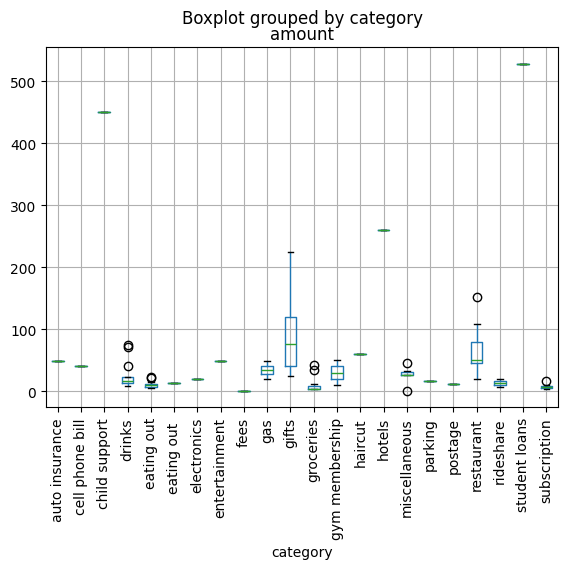

In [31]:
df_2.boxplot(
    column='amount',
    by='category',
    rot=90
)

Notice the different shapes of the various categories. Some have larger range than others. Some categories only occur once while others have many transactions.

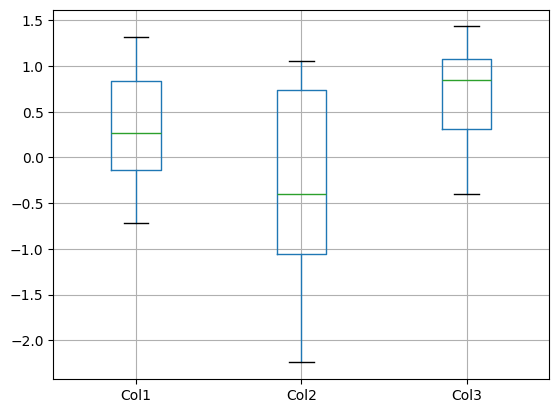

In [32]:
# Example use of the box plot with generic data
df = pd.DataFrame(
    np.random.randn(10, 4),
    columns=['Col1', 'Col2', 'Col3', 'Col4']
)

boxplot = df.boxplot(column=['Col1', 'Col2', 'Col3'])  

In [33]:
# Checking processed_df implementing some more changes.
processed_df.head(10)

,txn_id,date,day,description,category,amount
0,0,2023-12-01,friday,Tlatoani Barbershop,haircut,60.00
1,1,2023-12-01,friday,Andy's Boy,meds,60.00
2,2,2023-12-01,friday,Nob Hill Foods,drinks,13.43
3,3,2023-12-01,friday,TicketWeb,entertainment,49.20
4,4,2023-12-02,saturday,Lyft,rideshare,6.00
5,5,2023-12-02,saturday,street vendor,eating out,5.00
6,6,2023-12-02,saturday,Hilton Hotel,hotels,259.66
7,7,2023-12-02,saturday,Mezcal,restaurant,73.74
8,8,2023-12-02,saturday,The Cheesecake Factory,restaurant,108.16
9,9,2023-12-02,saturday,Beverages & More,miscellaneous,26.88


Will now add another column that is the proportion spent per description. First, will calculate the total dollar amount spent using the sum function. Then, use aggregate operation GROUP BY with sum and divide by total spent to get a proportion of total spent by description. Will then create a horizontal bar plot.

In [34]:
df_3 = processed_df
total_spent = df_3['amount'].sum().round(2)
print(total_spent)

4513.41


In [35]:
df_4 = df_3
df_4 = df_4.drop(columns=['txn_id', 'date', 'day', 'category'])
df_4 = df_4.groupby('description', as_index=False).sum()
df_4['proportion'] = df_4.apply(lambda row: row['amount'] / total_spent, axis=1)
df_4 = df_4.sort_values(by='proportion', ascending=True)
df_4 = df_4.tail(20)
print(df_4)

                     description  amount  proportion
38                        Mezcal   73.74    0.016338
63             Total Wine & More   75.06    0.016630
33       Lighthouse Publications   75.40    0.016706
20  Dubber's Oldtown Bar & Grill   79.74    0.017667
5                BJ's Restaurant   87.69    0.019429
4                     Applebee's   92.21    0.020430
44                Nob Hill Foods   95.16    0.021084
13      California Pizza Kitchen  102.82    0.022781
34                          Lyft  103.53    0.022938
59        The Cheesecake Factory  108.16    0.023964
68                          Vans  120.19    0.026630
9               Beverages & More  120.29    0.026652
30                         Kohls  120.79    0.026762
21                  East of Eden  165.00    0.036558
11            Buffalo Wild Wings  176.98    0.039212
62           Tlatoani Barbershop  180.00    0.039881
47               Pandora Jewelry  224.48    0.049736
24                  Hilton Hotel  259.66    0.

<Axes: ylabel='description'>

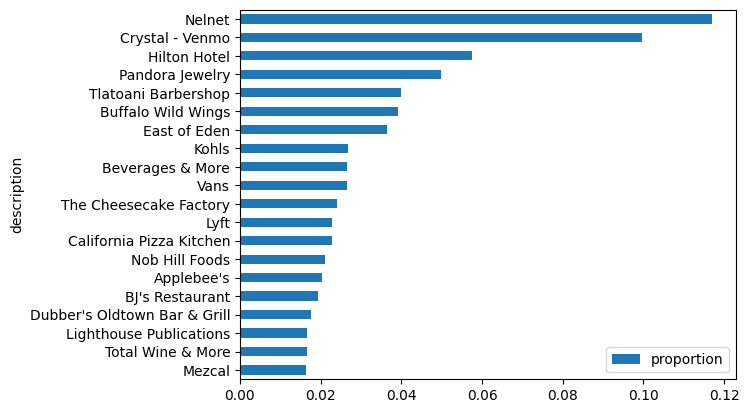

In [36]:
df_4.plot('description', 'proportion', kind='barh')

Check some arbitrary cell in the dataframe.

In [37]:
df_4.iloc[1,1]

np.float64(75.06)

# Section 4: Creating Synthetic Data

The final deliverable from this project will be a visual dashboard detailing relevant and crucial information. But will first incorporate some synthetic data to observe the performance of the dashboard without loading own personal financial data first. The Goal of this section is to test necessary code to build a robust dataset that this project is expected to analyze.

## Subsection 1: Pick a Random Date within a Given Range

Create a function that picks a random data within a given month. The idea is that reports will be created/available monthly. Will use the random, time, datetime modules.

In [43]:
# Random date function
def random_date(
        start_date,
        end_date
):
    """
    Generate a random datetime object between 2 dates.
    
    Args:
        start_date: Start date as a datetime object.
        end_date: End date as a datetime object.
    
    Returns:
        A randome datetime object between start_date and end_date.
    """
    start_time = time.mktime(
        datetime.strptime(start_date, "%Y-%m-%d").timetuple()
    )
    end_time = time.mktime(
        datetime.strptime(end_date, "%Y-%m-%d").timetuple()
    )
    random_timestamp = random.uniform(start_time, end_time)
    return datetime.fromtimestamp(random_timestamp)


Example usage of the new function. From it, will print the date, time, and day individually.

In [ ]:
start_date = '2023-12-01'
end_date = '2023-12-31'

x = random_date(start_date, end_date)

print(x.strftime("%Y-%m-%d"))
print(x.strftime("%H:%M:%S"))
print(x.strftime('%A'))

2023-12-28
21:45:07
Thursday


Will use iteration (probably for-loop) to populate two lists that will be columns in a synthetic dataset. The `num_data_pts` variable will be global because it is an important metric that will determine the size of the financial data, i.e. number of records/rows.

In [51]:
# Global variable. Number of dates in the list.
num_data_pts = 10

In [52]:
date_list = [] # Initiate an empty date list
day_list = [] # List of days
for x in range(num_data_pts):
    y = random_date(start_date, end_date)
    date_list.append(y.strftime("%Y-%m-%d"))
    day_list.append(y.strftime("%A"))

In [53]:
print(day_list)
print(date_list)

['Sunday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Wednesday', 'Wednesday', 'Monday', 'Friday']
['2024-01-07', '2024-01-13', '2024-01-21', '2024-01-11', '2024-01-30', '2024-01-10', '2024-01-03', '2024-01-17', '2024-01-08', '2024-01-05']


Successfully populated two lists with date and corresponding day. Will now practice joining both lists into a dataframe. Convert each list into a Pandas Series, then concatenate the series to form a dataframe.

In [54]:
# List 1 is date_list. List 2 is day_list.

s1 = pd.Series(date_list, name='Date')
s2 = pd.Series(day_list, name='Day')

df = pd.concat([s1, s2], axis=1)
print(df)

         Date        Day
0  2024-01-07     Sunday
1  2024-01-13   Saturday
2  2024-01-21     Sunday
3  2024-01-11   Thursday
4  2024-01-30    Tuesday
5  2024-01-10  Wednesday
6  2024-01-03  Wednesday
7  2024-01-17  Wednesday
8  2024-01-08     Monday
9  2024-01-05     Friday


## Subsection 2: Creating a Dictionary of Descriptions and Categories

Will now create a dictionary with some sample descriptions and categories for expenses. Practice how to extract wanted data and process it or manipulate it for firther analysis.

In [58]:
desc_and_cat = {
    "McBob's": "eating out",
    "Star Coffee": "eating out",
    "US Dept. of Education": "student loans",
    "Applebee's": "restaurant",
    "Circuit City": "electronics",
    "Mezcal": "restaurant",
    "DoubleTree": "hotel",
    "Total Wine & More": "drinks",
    "Pandora Jewelry": "gift",
    "Uber": "rideshare",
    "California Pizza Kitchen": "restaurant",
    "Lyft": "rideshare",
    "Kohls": "apparel",
    "Dubber's Oldtown Bar & Grill": "drinks",
    "East of Eden": "meds",
    "Lighthouse Publications": "miscellaneous",
    "Nob Hill Foods": "groceries",
    "Some Barbershop": "haircut",
    "Vans": "apparel"
}


Want to randomly pick elements from the dictioinary created above.

In [59]:
# Get key only
def pick_random_key(data):
    """
    Pick a random key from a dictionary.

    Args:
        data (dict): The dictionary to pick from.

    Returns:
        The randomly picked key, or None if the dictionary is empty.
    """
    if not data:
        return None
    return random.choice(list(data))

# Get value only
def pick_random_value(data):
    """
    Pick a random value from a dictionary.astimezone

    Args:
        data (dict): The dictionary to pick from.

    Returns:
        The randomly picked value, or None if the dictionary is empty.

    """
    if not data:
        return None
    return random.choice(list(data.values()))

# Function to pick random key-value pair from dictionary
def pick_random_item(data):
    """
    Pick a random key-value pair (item) from a dictionary.astimezone

    Args:
        data (dict): The dictionary to pick from.

    Returns:
        A tuple containing the randomly picked key-value pair, or None if the dictionary is empty.   
    """
    if not data:
        return None
    return random.choice(list(data.items()))



In [60]:
# Test function above
random_key = pick_random_key(desc_and_cat)
print(f"Random key: {random_key}")

random_value = pick_random_value(desc_and_cat)
print(f"Random value: {random_value}")

random_item = pick_random_item(desc_and_cat)
print(f"Random item: {random_item}")

Random key: Applebee's
Random value: electronics
Random item: ('East of Eden', 'meds')


In [61]:
random_item_2 = pick_random_item(desc_and_cat)
print(f"Random item: {random_item_2}")

random_item_3 = pick_random_item(desc_and_cat)
print(f"Random item: {random_item_3}")

random_item_4 = pick_random_item(desc_and_cat)
print(f"Random item: {random_item_4}")

Random item: ("Applebee's", 'restaurant')
Random item: ('Vans', 'apparel')
Random item: ('Vans', 'apparel')


Populate an initiated list to store various transactions.

In [ ]:
num_data_pts = 10 # Number of dates in the list
trx_list = [] # Initiate an empty date list
for x in range(num_data_pts):
    y = pick_random_item(desc_and_cat)
    trx_list.append(y)

In [ ]:
print(list(trx_list))

In [ ]:
type(trx_list)

A variation of the above logic but will try to populate different lists, one for description another for category.

In [ ]:
num_data_pts = 10 # Number of dates in the list
desc_list = [] # Initiate an empty description list
cat_list = []
for x in range(num_data_pts):
    y = pick_random_item(desc_and_cat)
    desc_list.append(y[0])
    cat_list.append(y[1])

In [ ]:
print(cat_list)

Turn a few of the tuples above into a dataframe.

In [ ]:
print(list(random_item_2))

In [ ]:
desc = []
desc.append(list(random_item)[0])
desc.append(list(random_item_2)[0])
desc.append(list(random_item_3)[0])
desc.append(list(random_item_4)[0])
print(desc)

In [ ]:
category = []
category.append(list(random_item)[1])
category.append(list(random_item_2)[1])
category.append(list(random_item_3)[1])
category.append(list(random_item_4)[1])
print(category)

In [ ]:
# Save the four tuples as lists and make a df from them

s3 = pd.Series(desc , name='Description')
s4 = pd.Series(category, name='Category')

df = pd.concat([s3, s4], axis=1)
print(df)

In [ ]:
num_data_pts = 10 # Number of dates in the list
date_list = [] # Initiate an empty date list
day_list = [] # List of days
for x in range(num_data_pts):
    y = random_date(start_date, end_date)
    date_list.append(y.strftime("%Y-%m-%d"))
    day_list.append(y.strftime("%A"))

In [ ]:
# Join two lists
s5 = pd.Series(date_list , name='Date')
s6 = pd.Series(day_list, name='Day')
s7 = pd.Series(desc_list, name='Description')
s8 = pd.Series(cat_list, name='Category')
df2 = pd.concat([s5, s6, s7, s8], axis=1)
df2


In [ ]:
df2['Category'].unique()

Function to add new column with dollar amount based of category column.

In [ ]:
def amount(row):
    if row['Category'] == 'haircut':
        val = round(random.uniform(45.00, 70.05))
    else:
        val = 0.00

#     def f(row):
#     if row['A'] == row['B']:
#         val = 0
#     elif row['A'] > row['B']:
#         val = 1
#     else:
#         val = -1
#     return val

# import random

# def random_float_2_decimals(min_val, max_val):
#   """Generates a random float number with two decimal places 
#   between min_val and max_val (inclusive).
#   """
#   random_num = random.uniform(min_val, max_val)
#   return round(random_num, 2)

# # Example usage:
# min_value = 1.5
# max_value = 10.7
# random_number = random_float_2_decimals(min_value, max_value)
# print(random_number)

In [ ]:
df2['C'] = df2.apply(amount, axis=1)
df2

In [ ]:
import numpy as np
# Create a list of our conditions
conditions = [
    (df['Category'] == 'haircut'),
    (df['Category'] == 'eating out'),
    (df['Category'] == 'miscellaneous'),
    (df['Category'] == 'groceries'),
    (df['Category'] == 'drinks'),
    (df['Category'] == 'meds'),
    (df['Category'] == 'student loans'),
    (df['Category'] == 'apparel'),
    (df['Category'] == 'rideshare')
]

# List of values we want to assign for each condition
values = [
    round(random.uniform(45.00, 70.05)),
    round(random.uniform(5.25, 45.50)),
    round(random.uniform(10.10, 110.05)),
    round(random.uniform(15.00, 75.05)),
    round(random.uniform(25.00, 125.05)),
    round(random.uniform(20, 30)),
    round(random.uniform(87.90, 176.90)),
    round(random.uniform(55.12, 89.03)),
    round(random.uniform(15.10, 28.90))
]

# Create a new column and use np.select to assign values to it using our list
df2['Amount'] = np.select(conditions, values)

df2

In [ ]:
df2

In [ ]:
import numpy as np

def amount(value):
    if value == 'haircut':
        return round(random.uniform(45.00, 70.05), 2)
    elif value == 'eating out':
        return round(random.uniform(5.25, 45.50), 2)
    elif value == 'miscellaneous':
        return round(random.uniform(10.10, 110.05), 2)
    elif value == 'groceries':
        return round(random.uniform(15.00, 75.05), 2)
    elif value == 'drinks':
        return round(random.uniform(25.00, 125.05), 2)
    elif value == 'meds':
        return round(random.uniform(20, 30), 2)
    elif value == 'student loans':
        return round(random.uniform(87.90, 176.90), 2)
    elif value == 'apparel':
        return round(random.uniform(55.12, 89.03), 2)
    elif value == 'rideshare':
        return round(random.uniform(15.10, 28.90), 2)

df2['Amount'] = df2['Category'].map(amount)

df2

In [ ]:
# End of "prototyping_notebook.ipynb"